# 2D GAN of s1 vs s2

s1 vs s2 is an important relationship for the GAN to understand and to be able to recreate. This notebook creates a GAN which accurately recreates a 2D histogram. It is completed in Google Colab for the extra computing power it offered.

We tried producing a 2D histogram. In this script to test the potential of it comapred to a scatter compared to a histogram.

<font color='orange'>16/11/19 - It has been brought to our attention that the S1 and S2 variables have not been accurately reproduced in this dataset. </font>


In [0]:
pip install uproot

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd gdrive/My\ Drive/test_run

/content/gdrive/My Drive/test_run


Import relevant libraries & use uproot to open it.

In [0]:
import uproot
import pandas
import matplotlib.pyplot as plt
import numpy as np

tree = uproot.open("outRunNeutron2.root")["dstree"]

## Understand the data

The different variables contained within the tree. This is usually done at the start of every Jupyter notebook to allow me to make sure I have the variables and the types of the variables available. Generally this is good habit and is something I would recommend. 

If you have problems with a variable, I would strongly recommend opening the file in a TBrowser in root.

Some variables are given as lists of lists, and therefore need to be 'unpacked'.

The different variables contained within the tree.

In [0]:
tree.show()

ev                         (no streamer)              asdtype('>i4')
pdg                        (no streamer)              asdtype('>i4')
ene0                       (no streamer)              asdtype('>f4')
s1ene                      (no streamer)              asdtype('>f4')
s2ene                      (no streamer)              asdtype('>f4')
veto_visene                (no streamer)              asdtype('>f4')
mu_visene                  (no streamer)              asdtype('>f4')
tpcene                     (no streamer)              asdtype('>f4')
vetoene                    (no streamer)              asdtype('>f4')
muene                      (no streamer)              asdtype('>f4')
ene                        (no streamer)              asdtype('>f4')
x                          (no streamer)              asdtype('>f4')
y                          (no streamer)              asdtype('>f4')
z                          (no streamer)              asdtype('>f4')
r                          (no str

## Getting the s1 and s2 variables

From the list of variables stored in the root file, we can extract the relevant variables we would like to use to create a 2D histogram. Some of these variables may require further manipulation, and this is also done here.

norm1 and norm2 must be calualted by plotting the graph then finding the normalisation to make them both the same order of magnitude. 

(10000,)


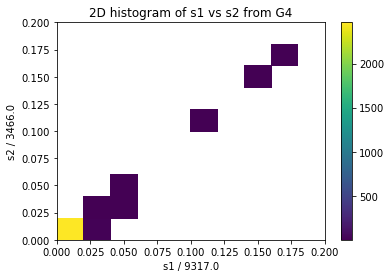

In [0]:
s1 = np.array(tree.array("s1ene"))
s2 = np.array(tree.array("s2ene"))
a1 = s1 / s1.max()
a2 = s2 / s2.max()
print(a1.shape)
train = np.matrix([a1,a2])
train = train.T
train = np.array(train)
plt.hist2d(a1, a2, bins=10, range=[[0, 0.2], [0, 0.2]],cmin = 1, density=True)
plt.xlabel(f"s1 / {round(s1.max())}")
plt.ylabel(f"s2 / {round(s2.max())}")
plt.title("2D histogram of s1 vs s2 from G4")
plt.colorbar()
plt.show()

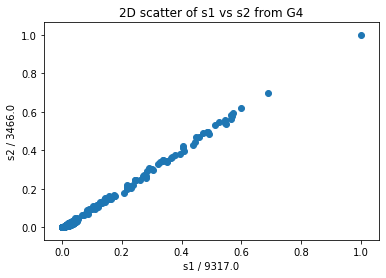

In [0]:
plt.scatter(a1, a2)
plt.xlabel(f"s1 / {round(s1.max())}")
plt.ylabel(f"s2 / {round(s2.max())}")
plt.title("2D scatter of s1 vs s2 from G4")  
plt.show()

We then set the number of training examples and the size of the noise. In this case, I set the noise size to 1000, thinking it had to be the same as the training data. However this is not the case, as the generator will transform the noise data into the appropriate number of points. 

Something that may be interesting to explore later is the effect of **varying the size of the noise** 

In [0]:
num_train = int(1e4)
noise_size = 1000
epochs     = 4000
batch_size = 1000

## Creation of the GAN

After setting some variables, the GAN is created. Generally there is no 'official documentation' on the correct setup of either the generator or disciminator. However the output of the disciminator should be a softmax, so it outputs a probability of the point being real/fake.

Binary Crossentropy is used to compare a probability (probaility image is real) with a 0,1 which is if it is real or fake. 

The generator is trying to maximise this, and make the disciminator bad at telling the difference, whilst the disciminator is trying to minimise this. 

A simple overview is found on this website: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

In [0]:
#  Create GAN

from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from keras.models     import Model, Sequential
from keras.optimizers import Adam

#Discriminator
#See how number of neurons are sae for each layer to reduce number of hyperparameters
d = Sequential(name="Discriminator")
d.add(Dense(50, activation="relu", input_shape=(2,)))
#Input shape would be number of parameters
d.add(Dense(50, activation="relu"))
d.add(LeakyReLU(0.2))
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
d.summary()

g = Sequential(name="Generator")
g.add(Dense(50, activation="relu", input_shape=(noise_size,)))
g.add(BatchNormalization())
g.add(Dense(50, activation="relu"))
g.add(BatchNormalization())
#THe number of outputs here should be the number of dimensions
g.add(Dense(2, activation="linear"))
g.summary()

input_layer = Input((noise_size,))
output_layer = d(g(input_layer))
gan = Model(input_layer, output_layer)
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
gan.summary()

Using TensorFlow backend.







Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 2,802
Trainable params: 2,802
Non-trainable params: 0
_________________________________________________________________

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                50050     
__________________________

In [0]:
def noisegenerator(batch_size, noise_size):
    return np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator loss: 0.65116817
Discriminator acc: 0.5


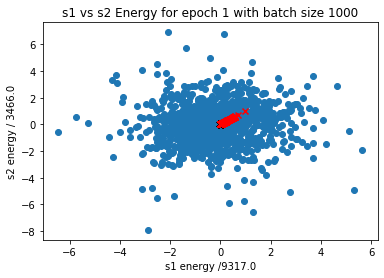

Discriminator loss: 0.5061107
Discriminator acc: 0.983


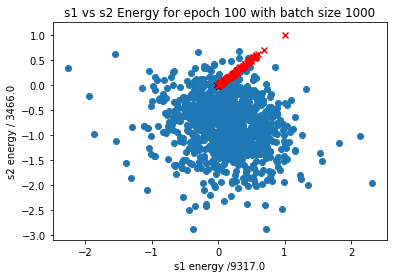

Discriminator loss: 0.53289866
Discriminator acc: 0.9215


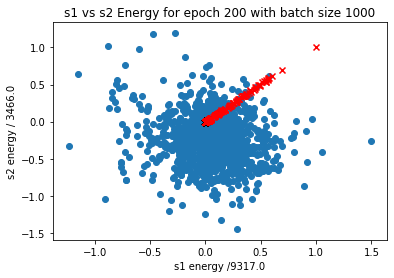

Discriminator loss: 0.46172112
Discriminator acc: 0.925


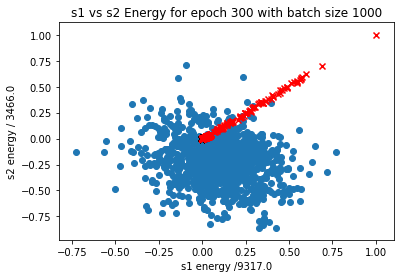

Discriminator loss: 0.45430169
Discriminator acc: 0.8755


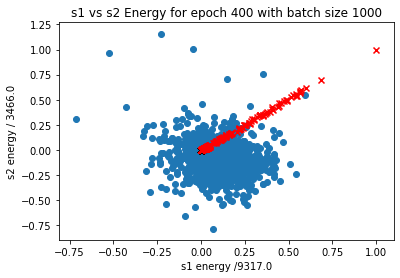

Discriminator loss: 0.541912
Discriminator acc: 0.7845


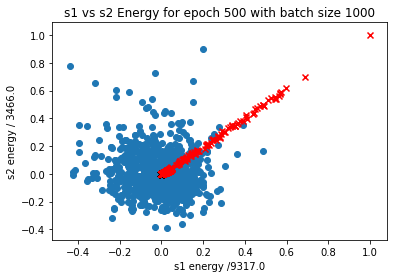

Discriminator loss: 0.5453927
Discriminator acc: 0.862


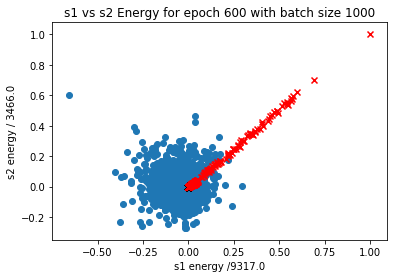

Discriminator loss: 0.512173
Discriminator acc: 0.9015


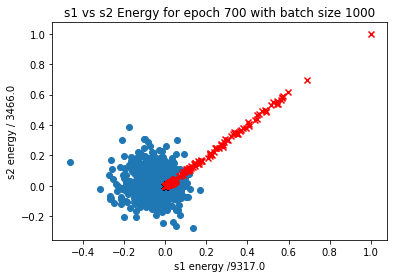

Discriminator loss: 0.4923609
Discriminator acc: 0.914


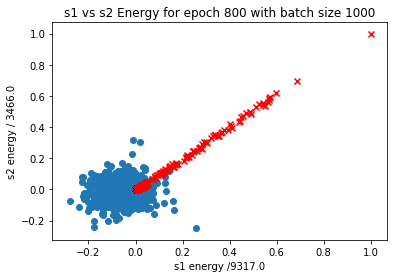

Discriminator loss: 0.5153535
Discriminator acc: 0.8535


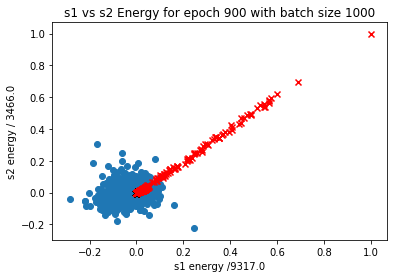

Discriminator loss: 0.51069915
Discriminator acc: 0.8955


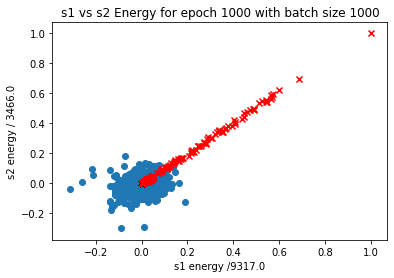

Discriminator loss: 0.55253613
Discriminator acc: 0.8535


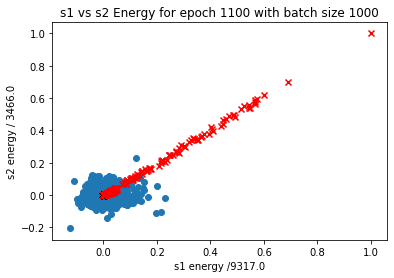

Discriminator loss: 0.5736274
Discriminator acc: 0.8275


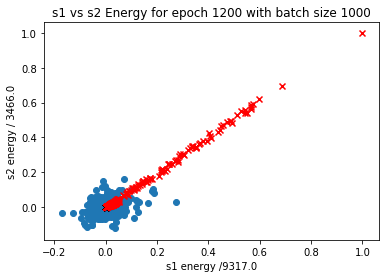

Discriminator loss: 0.5738268
Discriminator acc: 0.854


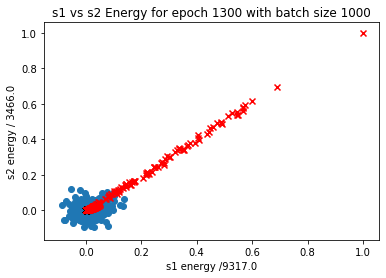

Discriminator loss: 0.54485023
Discriminator acc: 0.87


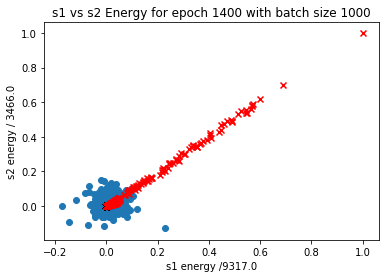

Discriminator loss: 0.5746443
Discriminator acc: 0.805


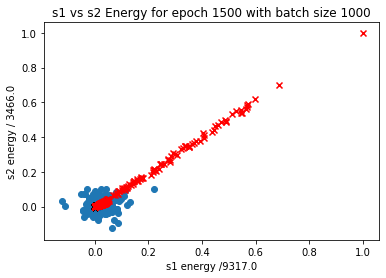

Discriminator loss: 0.56871593
Discriminator acc: 0.8665


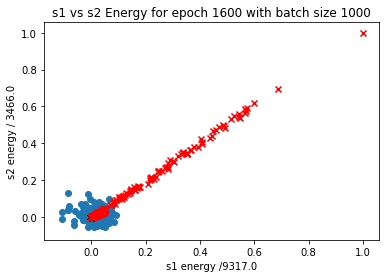

Discriminator loss: 0.5121789
Discriminator acc: 0.9205


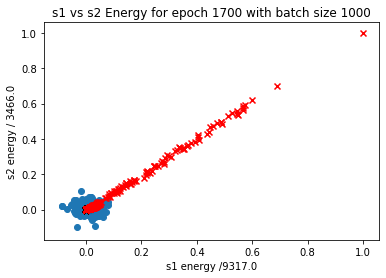

Discriminator loss: 0.5659032
Discriminator acc: 0.874


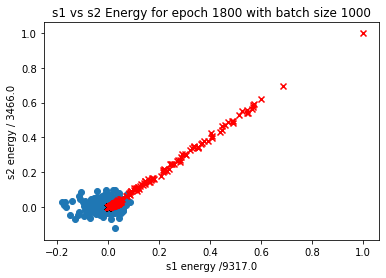

Discriminator loss: 0.48602015
Discriminator acc: 0.9005


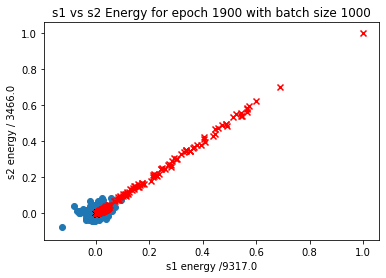

Discriminator loss: 0.5604565
Discriminator acc: 0.842


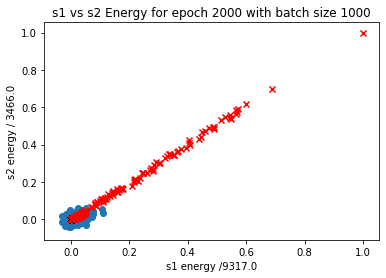

Discriminator loss: 0.5485165
Discriminator acc: 0.851


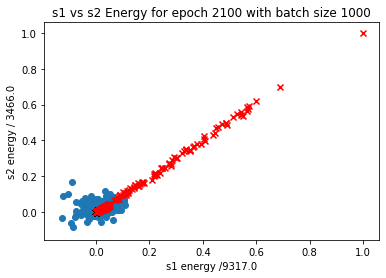

Discriminator loss: 0.5240737
Discriminator acc: 0.8415


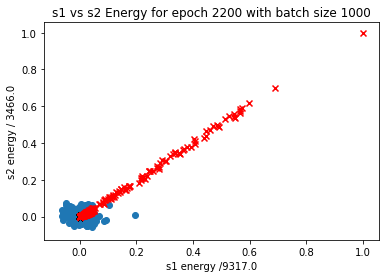

Discriminator loss: 0.4559835
Discriminator acc: 0.9205


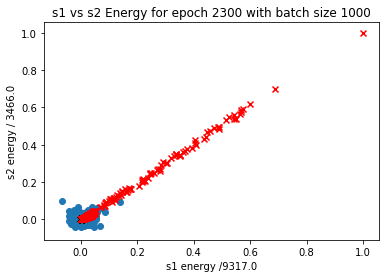

Discriminator loss: 0.42920673
Discriminator acc: 0.904


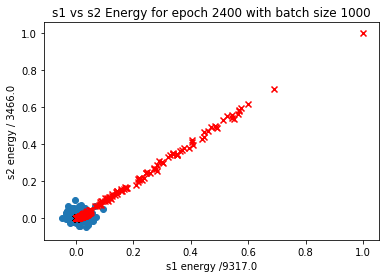

Discriminator loss: 0.5234781
Discriminator acc: 0.7825


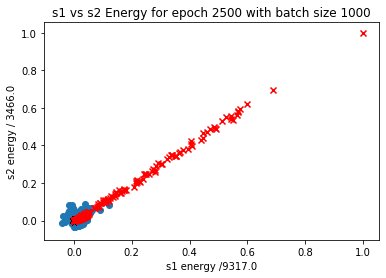

Discriminator loss: 0.44942674
Discriminator acc: 0.834


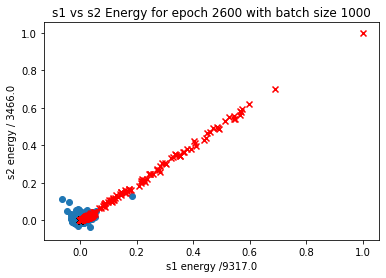

Discriminator loss: 0.34193036
Discriminator acc: 0.9435


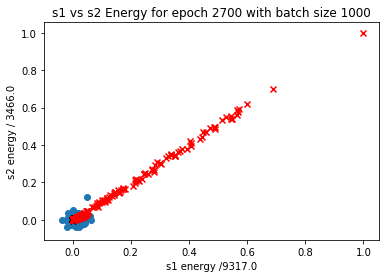

Discriminator loss: 0.55392605
Discriminator acc: 0.748


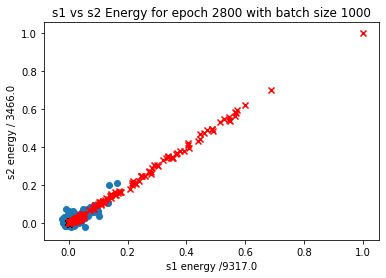

Discriminator loss: 0.50450855
Discriminator acc: 0.823


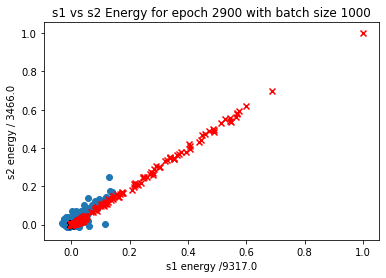

Discriminator loss: 0.42872125
Discriminator acc: 0.8505


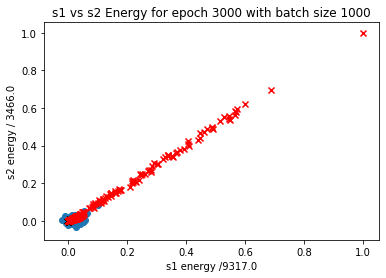

Discriminator loss: 0.45212966
Discriminator acc: 0.8615


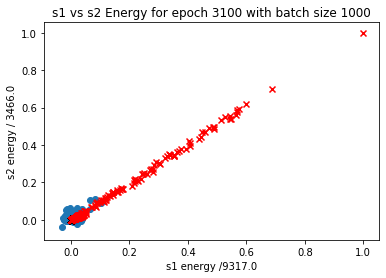

Discriminator loss: 0.37373328
Discriminator acc: 0.911


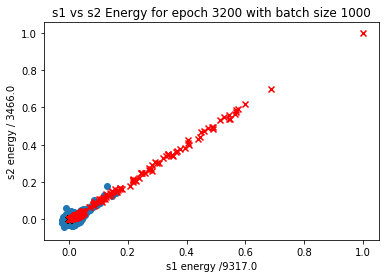

Discriminator loss: 0.31455034
Discriminator acc: 0.908


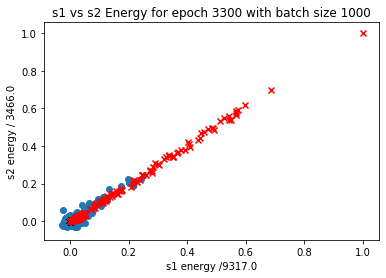

Discriminator loss: 0.2915256
Discriminator acc: 0.9255


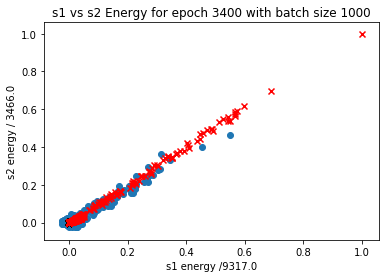

Discriminator loss: 0.38334796
Discriminator acc: 0.8685


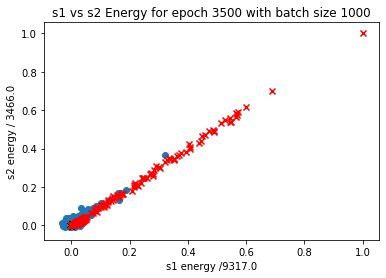

Discriminator loss: 0.25123712
Discriminator acc: 0.9525


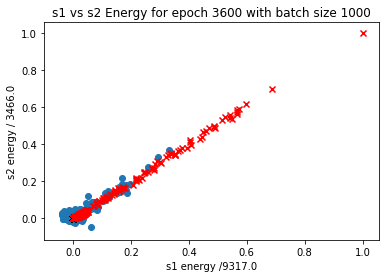

Discriminator loss: 0.32842383
Discriminator acc: 0.911


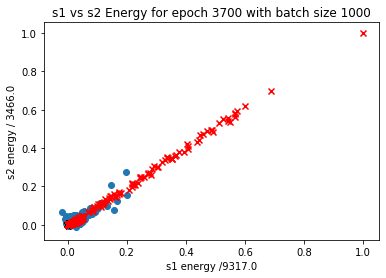

Discriminator loss: 0.2606035
Discriminator acc: 0.935


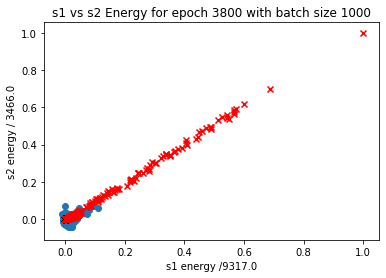

Discriminator loss: 0.19464001
Discriminator acc: 0.972


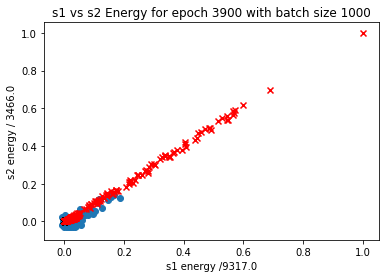

Discriminator loss: 0.21732831
Discriminator acc: 0.922


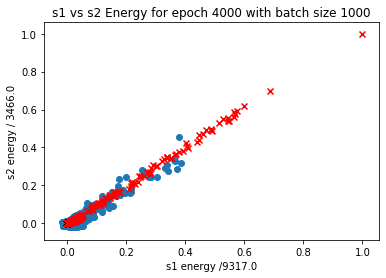

In [0]:
import tensorflow as tf
epochs_saved = []
acc = []
real_loss = []
real_acc = []
epoch_no = []
for e in range(epochs) :
    noise  = noisegenerator(batch_size, noise_size)

    batch_DS = train[np.random.choice(train.shape[0], batch_size, replace=True), :]
    #fake data made from predicting noise
    gen_DS   = g.predict(noise).reshape(batch_size, 2)
    
    #Real data has label [1.,0]
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    
    #Fake data has label [0.,1.]
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    
    #Combine real and generated data
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)

        
    noise  = noisegenerator(batch_size, noise_size)
    d.trainable = False
    gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise  = noisegenerator(batch_size, noise_size)
        gen_DS = g.predict(noise)
        dis_loss, dis_acc = d.train_on_batch(X, Y)
        print("Discriminator loss: " + str(dis_loss))
        print("Discriminator acc: " + str(dis_acc))
        #print("Generator: " + gan.train_on_batch(noise, real_label))
        epoch_no.append(e)
        acc.append(d_acc)
        #x, y = np.hsplit(gen_DS, 2)
        x = np.asarray(gen_DS)[:,0]
        y = np.asarray(gen_DS)[:,1]
        plt.scatter(x, y)
        plt.scatter(a1, a2, c = 'red', marker= 'x')
        plt.xlabel(f"s1 energy /{round(s1.max())}")
        plt.ylabel(f"s2 energy / {round(s2.max())}")
        plt.title(f"s1 vs s2 Energy for epoch {e+1} with batch size {batch_size}")
        plt.show()
        real_loss.append(d_loss)
        real_acc.append(d_acc)
        epochs_saved.append(e+1)

## Plotting Discriminator Accuracy

As the generator gets better at fooling the disciminator, the accuracy of the disciminator should decrease, as it finds it harder to tell the difference.

In [0]:
len(real_loss)

41

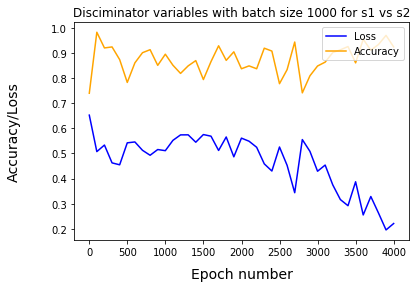

In [0]:
h3 = plt.plot(epoch_no,real_loss, color = 'blue', label = "Loss")
h4 = plt.plot(epoch_no,real_acc, color = 'orange', label = "Accuracy")
plt.xlabel("Epoch number", size=14, labelpad=10)
plt.ylabel("Accuracy/Loss", size=14, labelpad=30, rotation="vertical")
plt.title(f"Disciminator variables with batch size {batch_size} for s1 vs s2")
plt.legend(loc="upper right", fontsize=10)
plt.show()

## Checking 1D distributions

By learning 2D distributions, the 1D distributuon of s1 and s2 sepearately should also have been learnt. This is checked below, and uses a custom loss function which siply sums the differences in the sizes of the bins of the real and generated graphs.

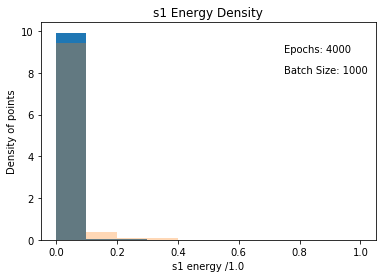

In [0]:
s1_true = plt.hist(a1, density = True,range = (0,1), bins = 10)
s1_gen = plt.hist(x, density = True,range = (0,1), bins = 10, alpha = 0.3)
s1_diff = s1_true[0] - s1_gen[0]

sum_s1_diff = 0
for i in range(len(s1_diff)):
  sum_s1_diff += abs(s1_diff[i])

#plt.text(0.75,10,f"Loss: {round(sum_s1_diff)}")
plt.text(0.75,9,f"Epochs: {epochs}")
plt.text(0.75,8,f"Batch Size: {batch_size}")
plt.xlabel(f"s1 energy /{round(a1.max())}")
plt.ylabel("Density of points")
plt.title("s1 Energy Density")
plt.show()


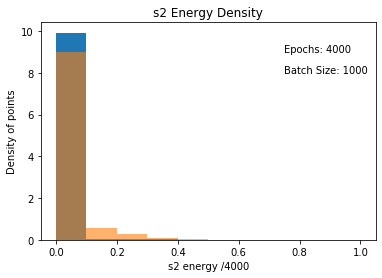

In [0]:
train_DS2 = a2
s2_true = plt.hist(a2, density = True,range = (0,1), bins = 10)
s2_gen = plt.hist(y, density = True,alpha = 0.6,range = (0,1), bins = 10)
plt.xlabel(f"s2 energy /{round(a2.max())}")
plt.ylabel("Density of points")
plt.title("Distribution of s2 Energy")
s2_diff = s2_true[0] - s2_gen[0]

sum_s2_diff = 0
for i in range(len(s1_diff)):
  sum_s2_diff += abs(s2_diff[i])


#plt.text(0.75,10,f"Loss: {round(sum_s2_diff)}")
plt.text(0.75,9,f"Epochs: {epochs}")
plt.text(0.75,8,f"Batch Size: {batch_size}")
plt.xlabel("s2 energy /4000")
plt.ylabel("Density of points")
plt.title("s2 Energy Density")
plt.show()

In [0]:
s1_diff = s1_true[0] - s1_gen[0]
s2_diff = s2_true[0] - s2_gen[0]
sum_s1_diff = 0
sum_s2_diff = 0
for i in range(len(s1_diff)):
  sum_s1_diff += abs(s1_diff[i])
  sum_s2_diff += abs(s2_diff[i])

print("s1 difference is: " + str(sum_s1_diff))
print("s2_difference is: " + str(sum_s2_diff))

s1 difference is: 1.063829082486297
s2_difference is: 1.9000855190703776
